# GAN - Генеративно-состязательные нейронные сети

### TOC
* Введение
    * Задача генерации
    * Latent space
    * Наивный подход


* GAN - Генеративно-состязательная сеть (англ. Generative adversarial network, сокращённо GAN)
    * Дискриминатор
    * GAN - принципы работы
    * Пример генерации точек на параболе


* DCGAN (Deep Convolutional Generative Adversarial Nets)
    * DCGAN - GAN для генерации изображений
    * deconv - обратные свёртки
    * Пример генерации изборажений


* cGAN - Условные порождающие состязательные сети (Conditional Generative Adversarial Nets)
    * Принципы работы cGAN
    * Модификации cGAN


* GAN Zoo
    * ProGAN - метод обучения сетей до высокого разрешения
    * Domain Transfer Network - перенос стиля с помомщью GAN
    * SRGAN и StackGANs - сети для увеличения разрешения
    * pix2pix - генерация изображения по его рисунку или из сегментации
    * Семантическая генерация - изображение по входному вектору из целевых свойств
    * ControlGAN и Text to Image - генерация изображения по текстовому описанию

* Заключение

* Ссылки

## Введение

Когда мы изучаем окружающий мир, то у нас нет ответов что представляет из себя окружающая действительность, однако, со временем, мы учимся распознавать образы, речь, движения, благодаря тому, что мы просто смотрим и слушаем!

Положим, если давать человеку бит в секунду, и, учитывая что человек живёт в среднем $10^9$ секунд, а так же то, что в мозге человека примерно $10^{14}$ нейронных связей, значит человек использует мозг на одну стотысячную. Откуда ему получить столько информации чтобы стать человеком? Изучать мир самому! Анализируя все входные источники своего тела: глаза, уши и так далее.

В курсе нейронных сетей, мы привыкли что изображения размечены, однако в жизни такие метки, отсутствуют. То есть преимущественно мы учимся без учителя. Однако мы способны к творчеству, мы можем писать картины, музыку. Придумывать и прогнозировать. Мы можем генерировать что-то новое.

Как подойти к такой задаче с помощью нейронных сетей?

## Поставим задачу генерации.

Мы имеем неразмеченные данные, и хотим генерировать новые данные, которые будут удовлетворять следующим условиям:
* Новые данные должны быть похожи на исходные.
* Но не повторять их в точности (или повторять, при случайном стечении обстоятельств).
* Чтобы результат генерации был различным при разных запусках, нам нужен элемент случайности.

### Эволюция в генерации изображений лиц:

[Множество примеров различных генераторов](https://thisxdoesnotexist.com)


<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img_licence/l13_0.png" width="700">

## Latent space

Поскольку мы обусловились о случайности, то нам эту случайность нужно реализовать. Если вспомнить сети, которые мы проходили, то всегда если мы подавали один и тот же вход, то получали один и тот же выход. Как реализовать случайность в нейронной сети? Случайно изменять веса сети? Есть способ лучше - давать в качестве входа случайных шум.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img_licence/l13_1.png" width="700">

Почему именно вектор? Почему не одно случайное число. Ответ таков: изменяя одно случайное число, мы будем перемещаться на очень небольшое расстояние и генерация будет однообразной. Поскольку мы физически не можем генерировать числа в бесконечных пределах, мы вынуждены использовать фиксированный диапазон.

В одномерном случае, взяв диапазон [0,1] у нас всего одна размерность нашего перемещения.
Если взять двухмерный, или трёхмерный случай, то у нас уже есть две и три **степени свободы**.

То есть случайный шум большой размерности даёт нам больше объёма для генерации. Это называется **input latent space** - входное латентное простанство.

Note: из-за неустоявшейся терминологии, случайное распределение на входе генератора называется латентным пространством, так же как и скрытое пространство в автоэнкодерах. Поэтому в этой лекции будем называть его **входным** латентным пространством. Так же встречается вариант: predefined latent space.

#### Какую размерность и форму выбрать?

Длина вектора (размерность латентного пространства) выбирается больше, чем количество разных независимых свойств объекта, которые мы хотим получить. Если длина 0, то случайности нет и генератор будет всегда производить один и тот же объект. Если длина 1, то будет шкала, вдоль которой будут расположены, например, генерируемые изображения. Для генератора лиц, это будет, в лучшем случае, шкала от молодой женщины блондинки к пожилому мужчине брюнету. Лучший способ выбрать длину вектора - это посмотреть похожую задачу в публикациях, взять подобную размерность, и начать экспериментировать с размерностью оттуда.

У большого латентного пространства есть минусы: увеличивая размерность латентного пространства мы можем расширить его настолько, что при обучении модели точек в этом латентром пространстве будет настолько мало, что в основном пространство будет состоять из пустот. Тогда модель будет крайне некачественно "понимать" что ей нужно генерировать в точке, которой не было на обучающей выборке.

Аналогичный вопрос встаёт и по поводу формы распределения входного латентного пространства. Как мы знаем из лекции про обучение сети, инициализация весов и нормализация имеют существенный вклад в работу модели. Поэтому, принято использовать многомерное нормальное распределение для input latent space, потому что оно лучше взаимодействует с весами модели и увеличивает сходимость.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img_licence/l13_2.png" width="600">

## Наивный подход
(как делать на практике НЕ нужно)

Давайте попробуем создать генератор точек на параболе. Самым тривиальным решением кажется подача случайного шума на вход сети и будем ожидать на выходе точки параболы. Проверим как это будет работать.

In [ ]:
import os
import numpy as np
import math
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import clear_output
from PIL import Image

import torch
import torch.nn as nn
from torch import autograd
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torchvision.utils import save_image

device = "cuda"

In [ ]:
def gen_pair(num=100):
    x = np.random.uniform(low=-1, high=1, size=(num,))
    y = x*x
    return np.hstack((x.reshape(-1,1), y.reshape(-1,1))) # Создадим num корректных точек (x,y) на параболе

pairs = gen_pair(100)
plt.scatter(pairs[:,0], pairs[:,1])
plt.title("Случайные точки на параболе,\nкоторые будем используем в качестве датасета.")
plt.show()

Возьмём размерность входного латентного пространства $ls = 3$ и объединим шум с точками в датасеты.

In [ ]:
n_batches = 10
batch_size = 128
ls = 3 # latent space

noise = np.random.normal(size=(n_batches*batch_size, ls))
noise = torch.tensor(noise, dtype=torch.float)
print(f"NN Input: noise.shape: {noise.shape}")

xy_pair = gen_pair(num = n_batches*batch_size)
xy_pair = torch.tensor(xy_pair, dtype=torch.float)
print(f"NN Output: xy_pair.shape: {xy_pair.shape}")

dataset = TensorDataset(noise, xy_pair) # model inputs, model outputs

len_tr = int(len(dataset)*0.8)
len_tst = len(dataset) - len_tr
trainset, testset = random_split(dataset,[len_tr,len_tst])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [ ]:
def get_test_loss(model,test_loader,loss_function):
    with torch.no_grad():
        loss_test_total = 0
        for samples, labels in test_loader:
            outputs = model(samples.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss_test_total += loss.item()
        return loss_test_total/len(test_loader)

Определим простую модель, которая будет ожидать шум на вход, и генерировать точки на выходе. (Обратите внимание, что функция активации на последнем слое отсутствует, поскольку мы не ограничиваем наш генератор в каком-то диапазоне.)

In [ ]:
class GenModel(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50,2))

    def forward(self, x):
        return self.model(x)

In [ ]:
epochs = 300
model = GenModel(latent_space = ls)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.L1Loss().to(device)

for epoch in range(epochs):
    loss_epoch = 0
    for samples, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(samples.to(device))
        loss = loss_function(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
        
    loss_test = get_test_loss(model,test_loader,loss_function)
    if epoch%100==0:
        print(f"Epoch={epoch} train_loss={loss_epoch/len(train_loader):.4} test_loss={loss_test:.4}")
        # test_image(model)

Посмотрим результаты генерации на шуме

In [ ]:
def test_image(model, ls = 3):
    model.cpu()
    noice = torch.tensor(np.random.normal(size=(1000, ls)), dtype=torch.float)
    xy_pair_gen = model(noice)

    xy_pair_gen = xy_pair_gen.detach().numpy()
    plt.scatter(xy_pair_gen[:,0], xy_pair_gen[:,1])
    plt.axis([-1, 1, 0, 1])
    plt.show()
    model.to(device)
test_image(model)

**Причина неудачи**

Как видно, модель обучается плохо. Нужно придумать как сделать так, чтобы точки "растолкать" из области, где парабола отсутствует. (Хотя в целом, обучать таким способом реально).

## Дискриминатор

Чтобы решить проблему сильного разброса точек (оттолкнуть их от пустот) можно наказывать нейронную сеть не напрямую лосс функцией, а сетью, которая будет говорить нам что точка лежит на параболе или не лежит. Однако, проверять это условие анализируя пару x, y на принадлежность к параболе плохая идея. Потому что точки получаются из случайного шума и ожидать что они попадут точно в параболу мы не имеем права. Поскольку попадание должно быть выше чем точность типа данных (32-bit floating point для torch.float). Мы рискуем не получить в процессе обучения ни одной точки, попавшей в параболу. Нам нужно дейстовать мягче.

Поэтому, определим сеть-классификатор точек (лежит/не лежит), которую назовём **дискриминатор или критик**.

In [ ]:
class DisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 15),
            nn.ReLU(),
            nn.Linear(15,1),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)

Итого мы имеем: генератор, выдающий точки то ли попадая в параболу, то ли не попадая в неё. А так же дискриминатор, который будет учиться их различать. Поэтому мы будем подавать на генератор синтетические правильные точки, считая их реальными, и точки, которые выдаёт генератор, считая их подделкой.

Таким образом, генератор будет учиться подражать реальным данным, а дискриминатор будет учиться отличать реальные точки, от подделок. 

Мы пришли к идее генеративно-состязательных нейронных сетей.

##  Generative adversarial network (GAN)

[2014 Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (**Cited by 33430!!!**)

[Видео разбор оригинальной статьи](https://youtu.be/eyxmSmjmNS0)

[Видео лекции самого Иана](https://channel9.msdn.com/Events/Neural-Information-Processing-Systems-Conference/Neural-Information-Processing-Systems-Conference-NIPS-2016/Generative-Adversarial-Networks)

Генеративно-состязательную сеть описал Иан Гудфеллоу из компании Google в 2014 году. Сейчас он возглавляет подразделение машинного обучения в Apple. Принцип состязательности в сети GAN нередко описывается через метафоры.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img_licence/l13_3.png" width="700">

### Генератор - фальшивомонетчик!

**НЕ УВЕРЕН КУДА ПОЙДЕТ. ЗАМЕТКИ:**

Еще со времен AlexNet мы знаем, что если мы что-то и умеем делать с нейросетями - так это классификаторы. В случае дискриминатора в классическом GAN - мы выполняем просетйшую из задач классификации - бинарную классификацию (либо *real*, либо *fake*). А вот задача генерации каким-то прямым образом на тот момент решена не была.

Что если мы будем использовать всю мощь классификатора, для того, что бы получить генератор?

Представим что у нас есть некий фальшивомонетчик и некий банкир. Назовем нашего фальшивомонетчика $G$ (или generator), а банкира — $D$ (или discriminator). У нас есть какое-то количество оригинальных денег $X$ для банкира, и пусть на выходе у него будет число диапазоном от нуля до единицы, чтобы оно выражало уверенность банкира в том, что выданные ему на рассмотрение деньги настоящие. Еще — поскольку фальшивомонетчик у нас нейронная сеть, ей нужны какие-то входные данные, назовем их $z$ - это наш случайный шум, который модель будет стараться превратить в деньги.

Тогда, очевидно, цель фальшивомонетчика — это максимизировать $D(G(z))$, то есть сделать так, чтобы банкир был уверен, что подделки — настоящие.

Цель банкира посложнее — ему нужно одновременно положительно опознавать оригиналы, и отрицательно — подделки. Запишем это как максимизацию $D(x)(1-D(G(z)))$. Умножение можно превратить в сложение, если взять логарифм, поэтому получаем:

Для банкира: максимизировать $log(D(X))+log(1-D(G(z)))$

Для фальшивомонетчика: максимизировать $log(D(G(z)))$

Математически - это игра двух игроков:

In [ ]:
#@markdown Запусти меня, что бы посмотреть на уравнение
from IPython.core.display import HTML

HTML("""
<style>
mark1 {
  background: linear-gradient(-100deg, hsla(48,92%,75%,.3), hsla(48,92%,75%,.7) 95%, hsla(48,92%,75%,.1));
  border-radius: 1em 0;
  padding: .5rem;
}

mark2 {
  background: linear-gradient(-100deg, hsla(10,92%,75%,.3), hsla(10,92%,75%,.7) 95%, hsla(10,92%,75%,.1));
  border-radius: 1em 0;
  padding: .5rem;
}
</style>

<script type="text/javascript" async
  src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=TeX-MML-AM_CHTML">
</script>

<script>MathJax.Hub.Config({ tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}})</script>

$\min\limits_{\Theta_g}  \max\limits_{\Theta_d} [\mathbb{E}_{x _\sim p(data)} 
log$ <mark1>$(D_{\Theta_d}(x)$</mark1>+$\mathbb{E}_{z _\sim p(z)} 
log(1-$<mark2>$D_{\Theta_d}(G_{\Theta_g}(z))$</mark2>)]

<br>
<p><mark1>Вероятность дискриминатора для real data x</mark1></p>
<br>
<p><mark2>Вероятность дискриминатора для сгенерированной fake data G(z)</mark2></p>

""")

Мы знаем, что дискриминатор максимизирует эту функцию относительно своих параметров $\theta_d$, где при фиксированном генераторе ${G}_{\theta_{g}}$ он выполняет двоичную классификацию: он присваивает вероятность 1 точкам данных из обучающего набора $E_{x∼p_{data}}$ и присваивает вероятность 0 сгенерированным выборкам $E_{z∼p(z)}$

Поскольку используется подход из теории игр, наша лосс-функция представлена как минимаксная функция. Дискриминатор пытается максимизировать целевую функцию, поэтому мы можем выполнить градиентный подъем целевой функции. Генератор пытается минимизировать целевую функцию, поэтому мы можем выполнить градиентный спуск для целевой функции. Посредством чередования градиентного подъема и спуска сеть можно обучить.

Градиентный подъем на дискриминаторе:


$\max\limits_{\theta_d} [\mathbb{E}_{x _\tilde{}p(data)} log(D_{\theta_d}(x)+\mathbb{E}_{z _\tilde{}p(z)} log(1-D_{\theta_d}(G_{\theta_g}(z)))]$

Градиентный подъем на генераторе:


$\min\limits_{\theta_g} \mathbb{E}_{z _\tilde{}p(z)} log(1-D_{\theta_d}(G_{\theta_d}(z)))$

Однако вместо того, чтобы минимизировать вероятность того, что дискриминатор будет правильным, мы максимизируем вероятность того, что дискриминатор ошибается. Поэтому мы выполняем градиентный подъем на генераторе в соответствии с этой целевой функцией.

$\max\limits_{\theta_g} \mathbb{E}_{z _\tilde{}p(z)} log(D_{\theta_d}(G_{\theta_d}(z)))$

В процессе совместного конкурентного обучения, если система достаточно сбалансирована, достигается минимаксное состояние равновесия, в котором обе сети значительно улучшили своё качество, и теперь сгенерированные изображения могут быть использованы практически как настоящие.

**НЕ УВЕРЕН КУДА ПОЙДЕТ. ЗАМЕТКИ:**

Если хорошенько подумать - то можно придти к выводу, что loss функция в GAN это не какая-то функция заданная людьми, а еще одна нейросеть

Подробнее о математике GAN-ов можно почитать в статье [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf)

**Преимущества GAN**
* Теоретические гарантии сходимости
* Можно обучать обычным SGD/Adam
* Решает в явном виде задачу generative modeling
* Но неявным образом (нейросети)

**Недостатки GAN**
* Нестабильное обучение
* Очень долгая сходимость
* Mode-collapsing
* Generator/Discriminator starvation
* Поиск оптимальных параметров - **pure luck**

### GAN Практический пример

Создадим две функции возвращающие батчи:

Первая функция будет создавать случайный вектор на вход генератора и метками классов будут единицы, потому что мы хотим чтобы генератор давал такие точки, чтобы классификатор их распознавал как единицы (верные). Поэтому лосс функция будет подгонять веса генератора к единицам.

In [ ]:
def get_g_batch(batch_size, latent_dim):
    g_input = torch.randn(size=(batch_size, latent_dim)).to(device)
    labels = torch.ones(size=(batch_size,)).to(device)
    return g_input, labels

Вторая функция будет давать батч на вход дискриминатора, смешивая:
* Истиные точки на параболе (чтобы обучать дискриминатор)
* Точки не на параболе (чтобы дискриминатор знал где "не парабола")
* Выход генератора как неверный (чтобы генератор не коллапсировал в одну верную точку)

In [ ]:
def get_mix_batch(batch_size, latent_dim, netG):
    types_of_points = []
    
    # Generate true pairs and true labels
    x = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
    true_pair = torch.vstack((x, x*x)).T.to(device)
    true_labels = torch.ones(size=(batch_size,)).unsqueeze(1).to(device)
    types_of_points.append(torch.hstack((true_pair, true_labels)))
    
    # Generate fake uniform pairs and fake labels
    if True:
        x_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        y_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        fake_pair = torch.vstack((x_fake, y_fake)).T
        fake_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((fake_pair, fake_labels)))

    # Generate points from generator and set labels as fake
    if True:
        gan_pair = netG(torch.randn(size=(batch_size, latent_dim)).to(device))
        gan_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((gan_pair, gan_labels)))
    
    # Stack all types of points
    z = torch.vstack(types_of_points)
    # Shuffle
    z=z[torch.randperm(z.size()[0])]
    
    # Split back to samples and labels
    mixed_pairs = z[:, :2]
    mixed_labels = z[:, 2]
    return mixed_pairs, mixed_labels

Для удобства обернём в функции шаги backpropagation дискриминатора и генератора

In [ ]:
def netD_step(netD, batchD, loss_func, optimizer):
    samples, labels = batchD
    optimizer.zero_grad()
    outputs = netD(samples.to(device))
    loss = loss_func(outputs.to(device), labels.unsqueeze(1).detach().to(device))
    loss.backward()
    optimizer.step()

In [ ]:
def netG_step(netD, netG, batchG, loss_func, optimizer):
    samples, labels = batchG
    optimizer.zero_grad()
    outputs = netD(netG(samples.to(device)))
    loss = loss_func(outputs.to(device), labels.unsqueeze(1).detach().to(device))
    loss.backward()
    optimizer.step()

Будем каждую эпоху отображать что уже умеет генерировать генератор

In [ ]:
def plot_gen(netG, epoch="Not provided"):
    Gin, _ = get_g_batch(1000, latent_dim)
    out = netG(Gin).cpu()
    plt.scatter(out.detach().numpy()[:, 0], out.detach().numpy()[:, 1], color="blue", s=1)
    plt.title(f'Generator points. End of epoch= {epoch+1}', fontsize=10)
    plt.axis([-1,1,-0.5,1])
    plt.show()

Поскольку сети обучаются по очереди, то создадим два оптимайзера.

In [ ]:
latent_dim = 5
batch_size = 128
batch_per_epoch = 1000
epochs = 5

netG = GenModel(latent_dim).to(device)
netD = DisModel().to(device)
loss_func = nn.BCELoss().to(device)
optD = torch.optim.Adam(netD.parameters(), lr=0.001)
optG = torch.optim.Adam(netG.parameters(), lr=0.001)

В цикле обучения будет создаваться батч данных (размера batch_size) для генератора, и батч из смеси точек (размера 3\*batch_size) для дискриминатора. С балансом данных подаваемых на обе сети можно эксперементировать.

In [ ]:
def train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG):
    for epoch in range(epochs):
        for _ in range(batch_per_epoch):
            batchG = get_g_batch(batch_size, latent_dim)
            batchD = get_mix_batch(batch_size, latent_dim, netG)
            
            netD.train(True)
            netG.train(False)
            netD_step(netD, batchD, loss_func, optD)
            
            netD.train(False)
            netG.train(True)
            netG_step(netD, netG, batchG, loss_func, optG)
            
        # clear_output()
        plot_gen(netG, epoch)

In [ ]:
train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG)

Сеть отлично обучилась при подаче в дискриминатор всех типов точек. Можно отключить некоторые типы и посмотреть что получится.

## DCGAN - Генерация изображений

С помощью GAN можно, разумеется, генерировать не только точки на параболе. Можно генерировать, например, изображения. Но поднимаются закономерные вопросы.

### Как из шума на входе сети получить изображение?

Самым простым ответом будет: взять шум, пропустить его через полносвязные слои и сделать rashape до нужного разрешения. В целом, это будет работать.


Однако **DCGAN - Deep Convolutional GAN** использует сверточные и сверточно-транспонированные (convolutional and convolutional-transpose) слои в дискриминаторе и генераторе соответственно. Впервые метод DCGAN был описан Рэдфордом и др. в статье "Обучение неконтролируемому представлению с помощью Глубоких Сверточных генеративных состязательных сетей".

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img_licence/l13_4.png" width="700">

Ниже видна разница в генерации при помощи исключительно полносвязных слоёв и при помощи обратных свёрток. Очевидно, результат DCGAN лучше чем GAN.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/gan_dcgan.png" width="600">

### Архитектура DCGAN

На вход порождающей сети поступает шум, который по факту представляет из себя вектор произвольной размерности. Отсюда следует, что нет никакой необходимости расчленять его на признаки с помощью сверточных слоев в отличие от дискриминатора, а требуется, наоборот, преобразовать в результирующее изображение. Для выполнения этой задачи будут использоваться так называемые разверточные (deconvolutional) слои, которые являются обратными к сверточным. Принцип их действия заключается в том, что они дополняют вход нулями до матрицы необходимого размера.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/dcgan.png" width="700">

### Convolution-Transpose Layer

Обратные свёртки/Развёртки (convolutional-transpose). 

Входное разрешение дополняется нулями (подобно паддингу) до такого разрешения, чтобы выходное разрешение было больше входного. Вы можете возразить: но ведь сильно увеличить изображение не получится! Для этого слоёв ставится несколько, чтобы каждый новый слой лучше восстанавливал то, что в него подают. Итеративно увеличивая разрешения, ядра свёрток учатся генерировать изображения.

Из изображения 2х2 в изображение 4х4:



<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/deconv.gif" width="300">


Из изображения 3х3 в изображение 5х5 с использованием паддинга:



<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/deconv_padding.gif" width="300">

[ссылка](https://github.com/vdumoulin/conv_arithmetic)


[Документация nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d)


<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/convtransponce_doc.png" width="700">

[ссылка](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d)

In [ ]:
x = torch.rand((1, 3, 10, 10))*255 # Like one 3-channal image with 10x10 size
x.shape

In [ ]:
convT = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=3)
y = convT(x)
y.shape  # One 8-chanells image with 12x12 size

Полученное изображение не похоже на входное - потому что были применены свёрточные ядра со случайными коэффициентами.

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(x[0].permute(1,2,0).detach().numpy().astype(np.uint8))
ax[1].imshow(y[0].permute(1,2,0).detach().numpy().astype(np.uint8))
plt.show()

### Пример обученного DCGAN

In [ ]:
use_gpu = True if torch.cuda.is_available() else False
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=use_gpu)
clear_output()

In [ ]:
num_images = 16
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

fig, ax = plt.subplots(figsize=(16*3, 2*3))
ax.imshow(torchvision.utils.make_grid(generated_images).permute(1, 2, 0).cpu().numpy(), interpolation='nearest', aspect='equal')
plt.show()

## Другие способы повышения разрешения  - Upsampling

Помимо обратных свёрток, существует другие методы повышения разрешения из низкой размерности.

Самый простой способ - выполнить повышение разрешения с помощью интерполяции. В PyTorch это осуществляется слоем [Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html)



In [ ]:
x = torch.rand((1, 3, 10, 10)) # Like one 3-channal image with 10x10 size
print("Input shape:", x.shape)
    
upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
y = upsample(x)

print("Output shape", y.shape)

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow((x[0].permute(1,2,0)*256).detach().numpy().astype(np.uint8))
ax[1].imshow((y[0].permute(1,2,0).detach().numpy()*256).astype(np.uint8))
plt.show()

## Практический пример DCGAN

Обучим DCGAN на датасете Fashion MNIST

In [ ]:
n_epochs=2  #number of epochs of training
batch_size=64 #size of the batches
lr=0.0002     #adam: learning rate
b1=0.5 #adam: decay of first order momentum of gradient
b2=0.999 #adam: decay of first order momentum of gradient
n_cpu=8 # number of cpu threads to use during batch generation
latent_dim=100 #dimensionality of the latent space
img_size=32 #size of each image dimension
channels=1 #number of image channels
sample_interval=100 #interval between image sampling

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

Обратите внимание, как преобразуется шум в генераторе:
* Сначала с помощью полносвязного слоя он преобразуется в первичные фичи
* Потом с помощью функции view, ресэмплится в картинку низкого разрешения
* Потом, проходя через conv_blocks поочерёдно применяются Upsample и ОБЫЧНЫЕ свёртки

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [ ]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Loss function
adversarial_loss = torch.nn.BCELoss()

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

In [ ]:
def show_gen_img(model, latent_dim=100):
    z = Tensor(np.random.normal(0, 1, (9, latent_dim)))
    sample_images = generator(z)
    sample_images = sample_images.cpu().detach()

    grid = make_grid(sample_images, nrow=3, ncols=3, normalize=True).permute(1,2,0).numpy()
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)
clear_output()

In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Tensor(imgs.shape[0], 1).fill_(1.0)
        fake = Tensor(imgs.shape[0], 1).fill_(0.0)

        # Configure input
        real_imgs = imgs.type(Tensor)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))
            show_gen_img(generator)

            # save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Чтобы картинки обрели приличный вид, хватает 2 эпох. Чтобы стали выглядеть хорошо - 5 эпох.

## cGAN - GAN с условием

cGAN расшифровывается как Conditional Generative Adversarial Net - это GAN с условием. Условие может быть любым, например, генерация конкретной цифры. В этом случае нам нужен уже размеченный датасет, для того чтобы обучить дискриминатор.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img_licence/l13_5.png" width="800">

Уловием в данном случае будет label, который на рисунке обозначен **Y**. Label добавляется к случайному шуму, тем самым мы говорим генератору генерировать случайное изображение нужного класса. Так же он подаётся в дискриминатор в качестве входа, чтобы дискриминатор знал какое изображение классифицировать как реальное, а какое как вымышленное.

Обучение в данном случае будет аналогичным обучению GAN, мы будем обучать сети, чередуя реальные данные и сгенерированные, добавив label.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/cGANS_results.png" width="600">

### Как закодировать метки?

Поскольку подавать в сеть числа от 0 до 9 (в случае MNSIT) нет смысла, то нужно придумать как подавать их в нейронную сеть. На помощь приходят Embeddings. Мы можем представить каждую метку в виде вектора с десятью элементами.

[Документация nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

In [ ]:
samples, labels = next(iter(dataloader))


label_emb = nn.Embedding(10, 10)

e = label_emb(labels)

print(f"Label: {labels[0]}")
print(f"Embedding for this label: {e[0]}")

После чего, эмбединги меток обычно склеиваются с входами сетей.

#### Почему нельзя подать просто число?

Если мы будем подавать просто число, например 0.1 для единицы, и 0.5 для пяти, то вход у нас будет непрерывным, что довольно нелогчино, тогда при небольшом изменении входа, мы будем генерировать другую цифру. А так же потому что сети будет сложнее выучить небольшие расхождения в этом небольшом интервале. В случае с веторным представлением мы избегаем этих проблем.

#### Модификации cGAN

Метки классов можно подавать не только способом, описанным выше. Можно вместо подачи их в дискриминатор сделать так, чтобы он их предсказывал - **Semi-Supervized GAN**.

Или же не подавать label в дискриминатор, но ждать от него классификации в соответствии с классом, который мы хотим получить от генератора - это **InfoGAN**

Ещё одна модификация cGAN - это **AC-GAN** (auxiliary classifier) в которой единственное различие заключается в том, что дискриминатор дожен помимо распознавания реальных и фейковых изображений ещё и классифицировать их. Он имеет эффект стабилизации процесса обучения и позволяет генерировать большие высококачественные изображения, изучая представление в скрытом пространстве, которое не зависит от метки класса.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/gans_zoo.png" width="900">

## Wasserstein GAN

Если поиграться с моделями, про которые мы говорили до этого можно заметить что две проблемы встречаются особенно часто:

**Mode collapse** - модель выдает одно и то же изображение независимо от того, какие входные данные ей подаются.

**Mode dropping** - часть данных в распределении не поддаются моделированию.


В 2017 году была опубликована работа [Wasserstein-GAN (WGAN)](https://arxiv.org/abs/1701.07875), которая эти проблмы в той или иной степени решила + внесла очень интересный теоретический и эмпирический вклад в обучение GANов, прежде всего в их стабилизацию и в то, что обучать их стало проще.

Wasserstein GAN архитектурно может быть любым, его фишка в новом лоссе - Wasserstein Metric. По другому этот лосс еще называют Earth-Mover distance. Давайте разберемся почему?

### Earth-Mover (EM) distance/ Wasserstein Metric

In [ ]:
!sudo apt update
!sudo apt install libcairo2-dev ffmpeg texlive texlive-latex-extra texlive-fonts-extra texlive-latex-recommended texlive-science tipa libpango1.0-dev
!pip install manim
!pip install IPython --upgrade


Давайте выполним простое упражнение по перемещению коробок с землей. У нас есть 6 коробок, и мы хотим переместить их слева в места, отмеченные серым квадратом справа. Для коробки №1 мы переместим ее из положения 1 в положение 7. Стоимость перемещения равна весу коробки, умноженному на расстояние. Для простоты мы зададим вес равным 1. Поэтому стоимость перемещения коробки №1 равна 6 (7-1).

Посмотрим в движении:

In [ ]:
from manim import *

Manim Community v0.9.0

In [ ]:
%%manim MovingAround

class MovingAround(Scene):
    def construct(self):
        # self.camera.background_color = "#ece6e2"
        boxes = []
        boxes_dest = []
        boxes_ghost = []

        for i in range(6):
            box = Square().scale(0.5)
            box_ghost = Square(color=GREY, fill_opacity=0.25).scale(0.5)

            box = box.set_x(-5)
            boxes.append(box)
            boxes_dest.append(box.copy())
            boxes_ghost.append(box_ghost)

        numberplane = NumberPlane().shift(0.5*DOWN, 0.5*RIGHT)

        boxes[1].set_y(1)
        boxes[2].set_y(2)
        boxes[3].set_x(-4)
        boxes[4].set_x(-3)
        boxes[5].set_x(-3).set_y(1)

        boxes_ghost[0] = boxes_ghost[0].set_x(1)
        boxes_ghost[1] = boxes_ghost[1].set_x(2)
        boxes_ghost[2] = boxes_ghost[2].set_x(3)
        boxes_ghost[3] = boxes_ghost[3].set_x(4)
        boxes_ghost[4] = boxes_ghost[4].set_x(3).set_y(1)
        boxes_ghost[5] = boxes_ghost[5].set_x(4).set_y(1)

        boxes_dest[0] = boxes_dest[0].move_to(boxes_ghost[0])

        texts = []
        texts_dest = []

        for i, box in enumerate(boxes):
            text = Text(str(i+1)).move_to(box)
            texts.append(text)
            texts_dest.append(text.copy())

        texts_dest[0] = texts_dest[0].set_x(1)

        group = VGroup(boxes[0], texts[0])
        group_dest = group.copy().set_x(1)

        d0 = Dot(color=BLUE).set_x(-5).set_y(-1)
        arrow_0 = Arrow(d0.get_center(), [1, -1, 0], buff=0)

        arrow_0_text = Text('+6').next_to(arrow_0, DOWN)

        self.add(*boxes, *texts, numberplane, *boxes_ghost)
        self.play(Transform(group, group_dest))
        self.wait()
        self.add(d0)
        self.play(Transform(d0, arrow_0))
        self.add(arrow_0_text)
        self.wait()


Мы можем переместить коробки разными путями. Например вот так:

In [ ]:
%%manim MovingAround

class MovingAround(Scene):
    def construct(self):
        # self.camera.background_color = "#ece6e2"
        boxes = []
        boxes_dest = []
        boxes_ghost = []

        for i in range(6):
            box = Square().scale(0.5)
            box_ghost = Square(color=GREY, fill_opacity=0.25).scale(0.5)

            box = box.set_x(-5)
            boxes.append(box)
            boxes_dest.append(box.copy())
            boxes_ghost.append(box_ghost)

        numberplane = NumberPlane().shift(0.5*DOWN, 0.5*RIGHT)

        boxes[1].set_y(1)
        boxes[2].set_y(2)
        boxes[3].set_x(-4)
        boxes[4].set_x(-3)
        boxes[5].set_x(-3).set_y(1)

        boxes_ghost[0] = boxes_ghost[0].set_x(1)
        boxes_ghost[1] = boxes_ghost[1].set_x(2)
        boxes_ghost[2] = boxes_ghost[2].set_x(3)
        boxes_ghost[3] = boxes_ghost[3].set_x(4)
        boxes_ghost[4] = boxes_ghost[4].set_x(3).set_y(1)
        boxes_ghost[5] = boxes_ghost[5].set_x(4).set_y(1)

        boxes_dest[0] = boxes_dest[0].move_to(boxes_ghost[0])

        texts = []
        texts_dest = []

        for i, box in enumerate(boxes):
            text = Text(str(i+1)).move_to(box)
            texts.append(text)
            texts_dest.append(text.copy())

        texts_dest[0] = texts_dest[0].set_x(1)

        groups = []
        groups_dest = []
        
        self.add(*boxes, *texts, numberplane, *boxes_ghost)
        self.wait()
        for i in range(6):
            group = VGroup(boxes[i], texts[i])
            group_dest = group.move_to(boxes_ghost[i])
            self.play(Transform(group, group_dest))
        self.wait()


[08/07/21 17:57:53] INFO     Animation 0 : Partial movie file        ]8;id=158958;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/450974505_1186765707_1790139916.mp                         
                             4'

[08/07/21 17:57:56] INFO     Animation 1 : Partial movie file        ]8;id=351415;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_3665336513_79191776.mp4'

[08/07/21 17:57:58] INFO     Animation 2 : Partial movie file        ]8;id=498516;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_1283164537_1057681885.mp4                         
                             '

[08/07/21 17:58:01] INFO     Animation 3 : Partial movie file        ]8;id=449576;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_2209274385_1400403228.mp4                         
                             '

[08/07/21 17:58:05] INFO     Animation 4 : Partial movie file        ]8;id=334491;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_1069873404_1018927884.mp4                         
                             '

[08/07/21 17:58:08] INFO     Animation 5 : Partial movie file        ]8;id=760667;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_2004280977_2878985816.mp4                         
                             '

[08/07/21 17:58:10] INFO     Animation 6 : Partial movie file        ]8;id=600975;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_919054352_4194152972.mp4'

[08/07/21 17:58:13] INFO     Animation 7 : Partial movie file        ]8;id=905554;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_3263697427_489316916.mp4'

                    INFO                                             ]8;id=799189;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:597
                             File ready at '/content/media/videos/co                         
                             ntent/1080p60/MovingAround.mp4'

                    INFO     Rendered MovingAround                               ]8;id=692907;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene.py\scene.py]8;;\:234
                             Played 8 animations

А можем и по другому:

In [ ]:
%%manim MovingAround

class MovingAround(Scene):
    def construct(self):
        # self.camera.background_color = "#ece6e2"
        boxes = []
        boxes_dest = []
        boxes_ghost = []

        for i in range(6):
            box = Square().scale(0.5)
            box_ghost = Square(color=GREY, fill_opacity=0.25).scale(0.5)

            box = box.set_x(-5)
            boxes.append(box)
            boxes_dest.append(box.copy())
            boxes_ghost.append(box_ghost)

        numberplane = NumberPlane().shift(0.5*DOWN, 0.5*RIGHT)

        boxes[1].set_y(1)
        boxes[2].set_y(2)
        boxes[3].set_x(-4)
        boxes[4].set_x(-3)
        boxes[5].set_x(-3).set_y(1)

        boxes_ghost[0] = boxes_ghost[0].set_x(1)
        boxes_ghost[1] = boxes_ghost[1].set_x(2)
        boxes_ghost[2] = boxes_ghost[2].set_x(3)
        boxes_ghost[3] = boxes_ghost[3].set_x(4)
        boxes_ghost[4] = boxes_ghost[4].set_x(3).set_y(1)
        boxes_ghost[5] = boxes_ghost[5].set_x(4).set_y(1)

        boxes_dest[0] = boxes_dest[0].move_to(boxes_ghost[0])

        texts = []
        texts_dest = []

        for i, box in enumerate(boxes):
            text = Text(str(i+1)).move_to(box)
            texts.append(text)
            texts_dest.append(text.copy())

        texts_dest[0] = texts_dest[0].set_x(1)

        groups = []
        groups_dest = []
        
        self.add(*boxes, *texts, numberplane, *boxes_ghost)
        self.wait()

        moves = np.arange(6)
        np.random.shuffle(moves)
        
        for i in moves:
            group = VGroup(boxes[i], texts[i])
            group_dest = group.move_to(boxes_ghost[i])
            self.play(Transform(group, group_dest))
        self.wait()


[08/07/21 18:01:35] INFO     Animation 0 : Using cached data (hash :    ]8;id=216163;file:///usr/local/lib/python3.7/dist-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:109
                             450974505_1186765707_1790139916)

[08/07/21 18:01:38] INFO     Animation 1 : Partial movie file        ]8;id=563551;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_2004280977_3378481452.mp4                         
                             '

[08/07/21 18:01:41] INFO     Animation 2 : Partial movie file        ]8;id=420546;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_2209274385_2678975754.mp4                         
                             '

[08/07/21 18:01:44] INFO     Animation 3 : Partial movie file        ]8;id=754237;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_3287821023_4066544951.mp4                         
                             '

[08/07/21 18:01:47] INFO     Animation 4 : Partial movie file        ]8;id=954852;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_3665336513_395793878.mp4'

[08/07/21 18:01:50] INFO     Animation 5 : Partial movie file        ]8;id=507619;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_919054352_3427206465.mp4'

[08/07/21 18:01:53] INFO     Animation 6 : Partial movie file        ]8;id=503748;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_1069873404_4143728485.mp4                         
                             '

[08/07/21 18:01:55] INFO     Animation 7 : Partial movie file        ]8;id=360457;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:415
                             written in '/content/media/videos/conte                         
                             nt/1080p60/partial_movie_files/MovingAr                         
                             ound/34786186_3263697427_2825269919.mp4                         
                             '

                    INFO                                             ]8;id=86740;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:597
                             File ready at '/content/media/videos/co                         
                             ntent/1080p60/MovingAround.mp4'

                    INFO     Rendered MovingAround                               ]8;id=501445;file:///usr/local/lib/python3.7/dist-packages/manim/scene/scene.py\scene.py]8;;\:234
                             Played 8 animations

Можно заметить, что не все перемещения будут иметь одинаковую стоимость. Какие-то будут дешевле, какие-то дороже. Расстояние Вассерштейна (или расстояние EM) - это стоимость самого дешевого "транспортного плана".

В применении к нейронным сетям, наша груда коробок слева - это одно распределение, а груда коробок с права - другое. И с помощью WGAN мы пытаемся из первого распреденеия сделать второе.

### Wasserstein loss

In [ ]:
#@markdown Wasserstein loss определен как:
#@markdown
#@markdown *(Запусти ячейку, что бы посмотреть на уравнение)*
from IPython.core.display import HTML

HTML("""
<style>
mark1 {
  background: linear-gradient(-100deg, hsla(48,92%,75%,.3), hsla(48,92%,75%,.7) 95%, hsla(48,92%,75%,.1));
  border-radius: 1em 0;
  padding: .5rem;
}

mark2 {
  background: linear-gradient(-100deg, hsla(10,92%,75%,.3), hsla(10,92%,75%,.7) 95%, hsla(10,92%,75%,.1));
  border-radius: 1em 0;
  padding: .5rem;
}

mark3 {
  background: linear-gradient(-100deg, hsla(90,92%,75%,.3), hsla(90,92%,75%,.7) 95%, hsla(90,92%,75%,.1));
  border-radius: 1em 0;
  padding: .5rem;
}

mark4 {
  background: linear-gradient(-100deg, hsla(200,92%,75%,.3), hsla(200,92%,75%,.7) 95%, hsla(200,92%,75%,.1));
  border-radius: 1em 0;
  padding: .5rem;
}

</style>

<script type="text/javascript" async
  src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=TeX-MML-AM_CHTML">
</script>

<script>MathJax.Hub.Config({ tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}})</script>

$W(P_r,P_\Theta) = $<mark3>$sup$</mark3><mark4>$_{||f||_L \leq 1}$</mark4><mark1>$(\mathbb{E}_{x \sim P_r}[f(x)]$</mark1>$-$<mark2>$\mathbb{E}_{x \sim P_\Theta}[f(x)])$</mark2>

<br>
<br>
<p><mark3>Supremum</mark3> <mark4>Lipschitz continuity</mark4> <mark1>Распределение real data</mark1> <mark2>Распределение fake data</mark2></p>
""")



#### Немного математических объясненний

**Cупре́мумом*** (лат. supremum — самый высокий) подмножества ${\displaystyle X}$ частично упорядоченного множества (или класса) ${\displaystyle M}$, называется наименьший элемент ${\displaystyle M}$, который равен или больше всех элементов множества ${\displaystyle X}$. Другими словами, супремум — это наименьшая из всех верхних граней.

**Lipschitz continuity**:

Функция $f$ в новой форме метрики Вассерштейна должна удовлетворять  $‖f‖_L \leq K$, то есть быть K-липшицевой непрерывной.

Действительная функция $f:\mathbb{R}→\mathbb{R}$ называется K-липшицевой непрерывной, если существует действительная константа $K \geq 0$ такая, что для всех $x_1$, $x_2$∈$\mathbb{R}$

$|f(x_1)-f(x_2)| \leq K|x_1-x_2|$

где $K$ известна как константа Липшица для функции $f(.)$. Функции, которые везде непрерывно дифференцируемы, являются непрерывными по Липшицу, поскольку производная, оцениваемая как $|f(x_1)-f(x_2)||x_1-x_2|$, имеет границы. Однако функция, непрерывная по Липшицу, может быть не везде дифференцируемой, например, $f(x)=|x|$.

Еще подробннее можно почитать в [этой статье](https://vincentherrmann.github.io/blog/wasserstein/).

### Назад к Wasserstein GAN

Авторы показали, что для того что бы GAN сходился, нужно каким-то образом обеспечить, чтобы дискриминатор подчинялся тому самому требованию K-липшица.

В оригинальной статье (то есть на практике) это было сделано с помощью (1) *weight clipping technique*.

К сожалению с этим подходом не все впорядке, так как возникает проблема того, что мы применяем слишком чрезмерную регуляризацию (это вредит качеству генерируемых изображений)

Мы можем определить *weight clipping* как:

$y_i = \text{min}(\text{max}(x_i, \text{min value}), \text{max value})$

И посчитать с помощью `torch`:

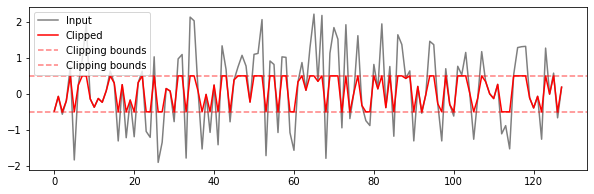

In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.randn(size=(128,))

min_val = -0.5
max_val = 0.5

x_clipped = torch.clamp(x, min_val, max_val)

fig = plt.figure(figsize=(10,3))
plt.plot(x, label='Input', color='black', alpha=0.5)
plt.plot(x_clipped, label='Clipped', color='red')
plt.axhline(min_val, ls='--', color='red', alpha=0.5, label='Clipping bounds')
plt.axhline(max_val, ls='--', color='red', alpha=0.5, label='Clipping bounds')
plt.legend()

В более поздней литературе за этим последовал метод (2) *gradient penalty*.

Его проблема в том, что *gradient penalty* дорого вычислять и штрафуются только определенные части функции. Подробнее можно почитать в статье [Improved Training of Wasserstein GANs (Wasserstein with Gradient Penalty)](https://arxiv.org/abs/1704.00028)

И затем (3) *spectral normalisation* (регуляризирует всю функцию и  вычислять дешево). Подробнее в статье [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957).

Спектральная нормализация стабилизирует обучение дискриминатора (критика) в GAN путем изменения масштаба тензора весов с помощью спектральной нормы.

*Spectral Norm* в `torch` можно посчитать так:

In [ ]:
from torch.nn.utils.parametrizations import spectral_norm

snm = spectral_norm(nn.Linear(20, 40))
print(snm)

ParametrizedLinear(
  in_features=20, out_features=40, bias=True
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): _SpectralNorm()
    )
  )
)


# Тонкости обучения GANов

[Статья - детальный разбор](https://beckham.nz/2021/06/28/training-gans.html)

## Частые/простые ошибки

* **Убедитесь что сгенерированые сэмплы в том же диапазоне, что и реальные данные.** Например, реальные данные `[-1,1]`, при этом генерируются данные `[0,1]`. Это не хорошо, так как это подсказка для дискриминатора. 
* **Убедитесь что сгенерированные сэмплы того же размера, что и реальные данные.** Например размер картинок в MNIST `(28,28)`, а генератор выдает `(32,32)`. В таком случае нужно либо изменить архитектуру генератора, что бы получать на выходе размер `(28,28)`, либо сделать ресайз реальных данных до `(32,32)`.
* **Старайтесь не использовать `BatchNorm`**. Проблема `BN` в том, что во время обучения его внутренняя статистика считается по минибатчу, а во время инференса она вычисляется как *moving average*, что в свою очередь может повлечь непредсказуемые результаты. Если архитектура GAN предполагает нормализацию - то лучше использовать **`InstanceNorm`**.
* **Визуализируйте свои лоссы в процессе обучения**. Для этого существует множество прекрасных библиотек (например `tensorboard`. Следить за бегущими по экрану цифрами от двух соревнующихся между собой лоссов - бессмысленно.



## Попробуйте дать преимущество дискриминатору

Если ваша версия GAN работает не так хорошо как вам хотелось бы, попробуйте дать своему дискриминатору преимущество, обучив его на относительно большее число итераций, чем генератор. Другими словами, чем лучше дискриминатор различает настоящие и фальшивые данные, тем лучше сигнал, который генератор может извлечь из него. Обратите внимание, что, эта логика не имела смысла во времена "до WGAN", поскольку слишком хорошая работа дискриминатора вредила обучению.

Например:


```
def train_on_batch(x, iter_, n_gen=5):
    # Generator
    ...
    ...
    if iter_ % n_gen == 0:
        g_loss.backward()
        opt_g.step()
        
    # Disc
    ...
    ...
    d_loss.backward()
    d_loss.step()
```

Где `iter_` - текущая итерация шага градиента, а `n_gen` определяет интервал между обновлениями генератора. В данном случае, поскольку он равен 5, мы можем считать, что это означает, что дискриминатор обновляется в 5 раз чаще, чем генератор.

Естественно работает не всегда и не везде. Но попробовать стоит


## Используйте ADAM

Можно обратить внимание, что почти во всех статьях по GAN используется ADAM. Сложно сказать почему так получается, но он работает и работает очень хорошо. Если качество вашего GAN оставляет желать лучшего - скорее всего оптимизатор тут не причем. Ищите ошибку где-то еще.

Параметр `epsilon` ADAM по умолчанию в PyTorch равен `1e-8`, что может вызвать проблемы после длительного периода обучения, например, лоссы потери периодически взрываются или увеличиваются. Подробнее об этом на [StackOverflow](https://stackoverflow.com/questions/42327543/adam-optimizer-goes-haywire-after-200k-batches-training-loss-grows) и в комментарии на [Reddit](https://www.reddit.com/r/reinforcementlearning/comments/j9rflf/intuitive_explanation_for_adams_epsilon_parameter/).

# GAN Zoo

GAN моделей настолько много, что нет смысла рассказывать о всех. Так или иначе, сейчас многие новые нейросети используют принципы GAN для обучения. Будь-то распознавание или сегментация.

[Самые современные генеративные модели](https://paperswithcode.com/methods/category/generative-models)

### ProGAN

[Progressive growing of GANs for improved quality, stability and variation](https://arxiv.org/abs/1710.10196) - метод, призванный ускорить обучение сети генерации изображений с помощью добавления слоёв во время генерации. Сначала сеть учится генерировать изображения низкого разрешения, потом добавляется слой, который создаёт более высокое разрешение из фич предыдушего слоя. Эта идея позволяет плавно обучать сеть и добиваться лучшей сходимости.


<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/ProGAN.gif" width="600">

[ссылка](https://discourse.world/h/2019/04/12/Pictures-from-rough-sketches:how-exactly-the-NVIDIA-GauGAN-neural-network-works)

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-23.gif" width="700">

[ссылка](https://arxiv.org/pdf/2102.12593.pdf)

### Domain transfer network

[Unsupervised Cross-Domain Image Generation](https://arxiv.org/abs/1611.02200)

Domain transfer network (DTN) - сеть, совмещающая в себе автоэнкодер, и gan для задачи переноса стиля.



<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-27.png" width="600">


[ссылка](https://arxiv.org/abs/1611.02200)

#### Результаты

From SVHN to MNIST

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/domain1.png" width="600">

[ссылка](https://arxiv.org/abs/1611.02200)

From Photos to Emoji 

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/domain2.png" width="600">

[ссылка](https://arxiv.org/abs/1611.02200)

### SRGAN и StackGANs

[Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802)

SRGAN (Super resolution GAN), StackGANs - сети для повышения разрешения изображений, отличающаяся от других сетей повышенным качеством восстановления мелких деталей и текстур изображения.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/SRGAN.JPG" width="700">

[ссылка](https://arxiv.org/abs/1609.04802)

Сравнение с другими методами повышения разрешения:

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/SRGAN_res.JPG" width="700">

[ссылка](https://arxiv.org/abs/1609.04802)

### Pix2Pix

[Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004)

Pix2Pix - сети, переводящая пиксельные рисунки в реалистичные изображения. Она тоже использует принципы GAN для работы.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/pix2pix.png" width="500">

[ссылка](https://arxiv.org/abs/1611.07004)

Попробовать сеть можно на [сайте 1](https://affinelayer.com/pixsrv/) и на [сайте 2](https://affinelayer.com/pix2pix/):

Ещё примеры:



<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/pix2pix2.png" width="900">


[ссылка]([ссылка](https://arxiv.org/abs/1611.07004))

### Семантическая генерация

Помимо шума, в модель можно подавать описание того что мы хотим получить. Это описание может быть разным, например текст или вектор заданных свойств.

Например:
* Класс объекта
* Углы и повороты
* Заданные параметры трансформаций
* Сегментация

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-06.png" width="700">

[ссылка]([ссылка](https://arxiv.org/pdf/1411.5928.pdf))

Результат:

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-07.png" width="500">

[ссылка]([ссылка]https://arxiv.org/pdf/1411.5928.pdf))

### Text to image

[Text-to-Image Generation with Attention Based Recurrent Neural Networks](https://arxiv.org/abs/2001.06658)

Описание может быть представлено в виде естественного текста.  Цель состоит в том, чтобы генерировать изображения из текста, а также позволить пользователю манипулировать синтетическими изображениями, используя описания на естественном языке, в одной структуре

Одна из возможных архитектур сетей text-to-image с использованием RNN-сети на входе:


<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-32.png" width="800">

[ссылка](https://arxiv.org/abs/2001.06658)

**ControlGAN** - Pytorch реализация  для управляемого преобразования текста в изображение. На входе используется эмбеддинг слов. Который подаётся во множество генераторов и дискриминаторов:


[Cтатья Controllable Generative Adversarial Network](https://arxiv.org/abs/1708.00598)

[Код ControlGAN](https://github.com/mrlibw/ControlGAN)

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/controlGAN.jpg" width="800">


[ссылка](https://arxiv.org/abs/1708.00598

Результаты:

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-31.png" width="500">


[ссылка](https://arxiv.org/abs/1708.00598)

Поэкспериментировать:

[Colab где можно вводить собственный текст](https://colab.research.google.com/drive/1_3sCa9QvUI0OqWqx2rQvsSh3C9xfPssZ?usp=sharing)

[Open AI DALL-E интерактив](https://openai.com/blog/dall-e/)

[OpenSource версия DALL-E](https://colab.research.google.com/drive/1b8va5g852hq3p7yro7xWY3Cc-bd2CRdv)

### Задача переноса стиля
    
[PapersWithCode Image Stylization](https://paperswithcode.com/task/image-stylization)

#### Постановка задачи

Перенос стиля (style transfer)  — одно из наиболее креативных приложений сверточных нейронных сетей. Взяв контент с одного изображения и стиль от второго, нейронная сеть объединяет их в одно художественное произведение.


<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/style_transfer-2.png" width="600">


<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/style_transfer-3.png" width="600">

Для целей переноса стиля [можно использовать GAN](https://towardsdatascience.com/style-transfer-with-gans-on-hd-images-88e8efcf3716) (но так делают редко):



<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img_licence/l13_6.png" width="600">

Сеть состоит из одного генератора (G) и сиамского дискриминатора (D): G принимает изображение-контент (А) на входе и выводит некое итоговое изображение G(A). Дискриминатор  принимает эти изображения и изображение-стиль (B) в качестве входных данных и выводит скрытый вектор.

Siamese Discriminator преследует 2 цели: дать информацию генератору, как создавать более реалистичные изображения, и поддерживать в этих поддельных изображениях корреляцию (то есть «контент») с исходными.

# Заключение

Принципы генеративно-состязательных сетей вышли далеко за пределы генерации из шума. Сейчас с помощью GAN создаются сложнейшие state-of-art сети для самых разнообразных задач. В лекции были рассмотрены самые главные модели: GAN - для генерации из шума, DCGAN - для генерации изображений, с помощью развёрток и cGAN - сети с генерацией по условию. 

Совмещая различные сети и подходы можно сконструировать множество самых разнообразных моделей.

# Ссылки

[Книга по генеративным сетям](https://habr.com/ru/company/piter/blog/504956/)

**GAN**

[Generative adversarial networks](https://deepgenerativemodels.github.io/notes/gan/)

**cDCGAN**

[github znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN](https://github.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN)

**StackGAN**

[StackGAN: Text to Photo-realistic Image Synthesis with Stacked Generative Adversarial Networks](https://arxiv.org/pdf/1612.03242v2.pdf)

[StackGAN++: Realistic Image Synthesis with Stacked Generative Adversarial Networks](https://arxiv.org/pdf/1710.10916.pdf)

[Let’s Read Science! “StackGAN: Text to Photo-Realistic Image Synthesis”](https://medium.com/@rangerscience/lets-read-science-stackgan-text-to-photo-realistic-image-synthesis-4562b2b14059)

[Deep Learning Generative Models for Image Synthesis and Image Translation](https://www.rulit.me/data/programs/resources/pdf/Generative-Adversarial-Networks-with-Python_RuLit_Me_610886.pdf)

Видео:

[youtube [StackGAN++] Realistic Image Synthesis with Stacked Generative Adversarial Networks | AISC](https://www.youtube.com/watch?v=PXWIaLE7_NU)

[youtube Text to Photo-realistic Image Synthesis with Stacked Generative Adversarial Networks](https://www.youtube.com/watch?v=crI5K4RCZws)

[github zeusm9/Text-to-Photo-realistic-Image-Synthesis-with-Stacked-Generative-Adversarial-Networks](https://github.com/zeusm9/Text-to-Photo-realistic-Image-Synthesis-with-Stacked-Generative-Adversarial-Networks)

**ControlGAN**

[github mrlibw/ControlGAN](https://github.com/mrlibw/ControlGAN)

[github taki0112/ControlGAN-Tensorflow](https://github.com/taki0112/ControlGAN-Tensorflow)

[Controllable Generative Adversarial Network](https://arxiv.org/pdf/1708.00598.pdf)

[Controllable Text-to-Image Generation](https://arxiv.org/pdf/1909.07083.pdf)

[Image Generation and Recognition (Emotions)](https://arxiv.org/pdf/1910.05774.pdf)

[Natural Language & Text-to-Image 2019](https://meta-guide.com/data/data-processing/text-to-image-systems/natural-language-text-to-image-2019)

**AC-GAN**

[DCGAN TUTORIAL](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

[How to Develop an Auxiliary Classifier GAN (AC-GAN) From Scratch with Keras](https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/)

[Understanding ACGANs with code[PyTorch]](https://towardsdatascience.com/understanding-acgans-with-code-pytorch-2de35e05d3e4)

[An Auxiliary Classifier Generative Adversarial Framework for Relation Extraction](https://arxiv.org/pdf/1909.05370.pdf)

[A Multi-Class Hinge Loss for Conditional GANs](https://openaccess.thecvf.com/content/WACV2021/papers/Kavalerov_A_Multi-Class_Hinge_Loss_for_Conditional_GANs_WACV_2021_paper.pdf)

[github lukedeo/keras-acgan](https://github.com/lukedeo/keras-acgan)